In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out


    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [2]:
pip install graphviz


     ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
     ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from graphviz import Digraph

In [31]:


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

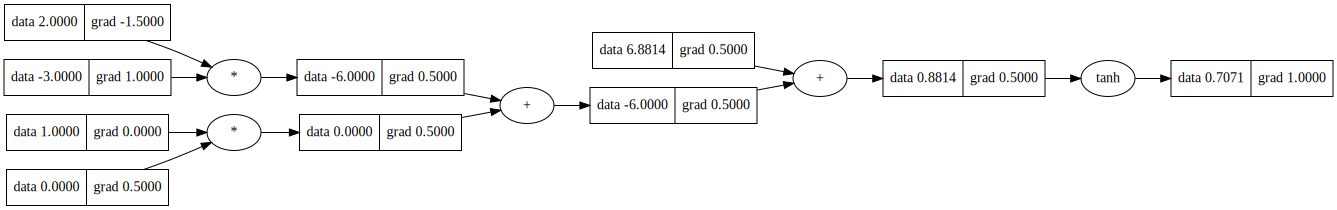

In [20]:
draw_dot(o)

In [19]:
o.backward()

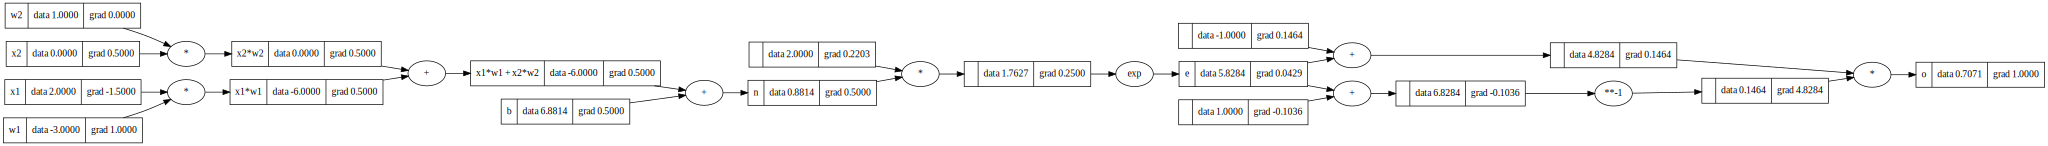

In [33]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp() ; e.label = 'e'
o = (e - 1)/(e + 1) 

o.label = 'o'

o.backward()
draw_dot(o)

In [91]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
       
        
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [ n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [99]:
x = [2.0 , 3.0 ,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.9629902598303486)

In [100]:
n.parameters()

[Value(data=-0.11481682917615665),
 Value(data=-0.44444323042185263),
 Value(data=0.32665880661954705),
 Value(data=-0.04361067872658819),
 Value(data=-0.433989415860623),
 Value(data=0.38358961952795334),
 Value(data=0.6003712091743485),
 Value(data=0.2431009627964691),
 Value(data=0.18114495860141333),
 Value(data=-0.21919730405245286),
 Value(data=0.8511386785612272),
 Value(data=-0.14191218345446788),
 Value(data=-0.3089242510403887),
 Value(data=0.23438709231359423),
 Value(data=0.2433075337023627),
 Value(data=-0.47782145736132575),
 Value(data=-0.14095338623233467),
 Value(data=0.34327745232573714),
 Value(data=0.062101535005826936),
 Value(data=-0.88222690662218),
 Value(data=0.8570598930079683),
 Value(data=0.8890368151639989),
 Value(data=0.2526766363790005),
 Value(data=-0.13714010120031483),
 Value(data=-0.13586160510128864),
 Value(data=0.5899546753201601),
 Value(data=-0.8582034674458556),
 Value(data=-0.9355204501629781),
 Value(data=-0.17710365982784348),
 Value(data=0.

In [46]:
import random

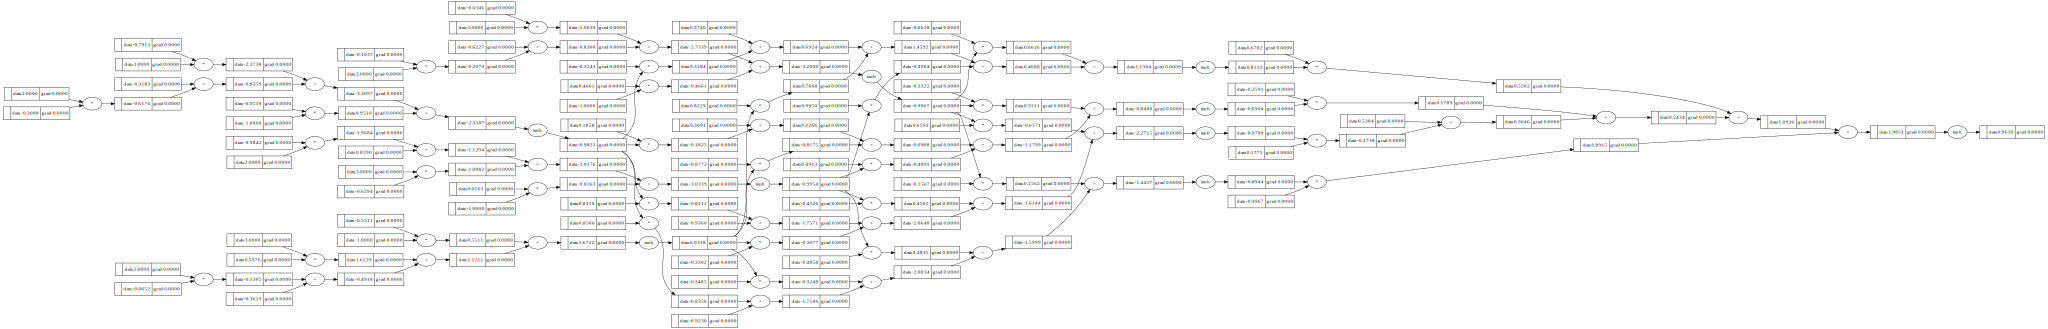

In [59]:
draw_dot(n(x))

In [93]:
xs = [[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0] #desired targets


In [112]:
for k in range(500):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
    
    #bakcward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #gradient descent
    for p in n.parameters():
        p.data += -0.09*p.grad
        
    print(k,loss.data)

0 0.0007341980444571134
1 0.0007326321812995809
2 0.0007310728029458447
3 0.0007295198695512759
4 0.0007279733415956045
5 0.0007264331798796294
6 0.0007248993455219451
7 0.0007233717999557842
8 0.0007218505049257809
9 0.0007203354224849316
10 0.0007188265149914077
11 0.0007173237451055697
12 0.0007158270757869268
13 0.0007143364702911452
14 0.000712851892167116
15 0.0007113733052540182
16 0.0007099006736784878
17 0.0007084339618517399
18 0.0007069731344667395
19 0.0007055181564955125
20 0.0007040689931862715
21 0.0007026256100608253
22 0.0007011879729118488
23 0.0006997560478001893
24 0.000698329801052363
25 0.0006969091992578382
26 0.0006954942092665992
27 0.0006940847981865182
28 0.0006926809333809266
29 0.0006912825824661129
30 0.0006898897133088861
31 0.0006885022940241961
32 0.0006871202929726981
33 0.0006857436787584263
34 0.0006843724202264727
35 0.000683006486460647
36 0.0006816458467812474
37 0.000680290470742773
38 0.0006789403281317009
39 0.0006775953889643357
40 0.000676255

393 0.0003956463506979785
394 0.0003951754883006202
395 0.0003947057142872502
396 0.00039423702492303816
397 0.0003937694164901301
398 0.0003933028852875874
399 0.00039283742763125836
400 0.00039237303985370617
401 0.00039190971830409683
402 0.0003914474593481169
403 0.0003909862593678661
404 0.0003905261147618105
405 0.0003900670219445995
406 0.00038960897734708456
407 0.00038915197741614966
408 0.0003886960186146405
409 0.0003882410974213037
410 0.00038778721033065253
411 0.00038733435385291504
412 0.0003868825245139311
413 0.00038643171885506837
414 0.000385981933433135
415 0.00038553316482029486
416 0.0003850854096039796
417 0.0003846386643867938
418 0.0003841929257864712
419 0.00038374819043573955
420 0.00038330445498226617
421 0.0003828617160885766
422 0.00038241997043195143
423 0.00038197921470437164
424 0.00038153944561243353
425 0.00038110065987724144
426 0.0003806628542343532
427 0.0003802260254337101
428 0.0003797901702395156
429 0.00037935528543020167
430 0.0003789213677983

In [113]:
ypred

[Value(data=0.9923339200714149),
 Value(data=-0.9886097893900899),
 Value(data=-0.9927698698051727),
 Value(data=0.9894944556374305)]